In [727]:
# -*- coding:utf-8 -*-
# basic
from datetime import datetime, timedelta
import datetime as dt
import time
import re
import sys
import pickle
import os
from tqdm import *
import multiprocessing
import math

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import imgkit

# machine learning
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold,KFold
import torch
from torch import nn
# import xgboost
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split 
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import gc

data_path = "../data/XPSG - available resources/"
train_path = "../data/train/" # path of processed training data
valid_path = "../data/valid/" # path of processed validation data
processed_path = "../data/processed/"
model_path = '../models/'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [728]:
import lxml
from lxml import etree

In [729]:
train_dir = data_path+"French Ligue One 20162017 season - Match Day 1- 19/" # path of raw data
player_info = data_path+"Players and IDs - F40 - L1 20162017.xml"
test_before_change_eg = data_path+"Example test base before changes specified in the Rules -f24-24-2016-853139-eventdetails_test_hackathon_1.xml"
test_change_eg = data_path+"Example test base file - f24-24-2016-853285-eventdetails_test_hackathon_2.xml"

In [664]:
def get_player_data(is_changed=False):
    """
    Provide the player's data containing their ids, names, team ids and team names.
    args:
        is_changed: If True, then get a player list who have changed team; if not, then get all.
    return:
        player_list: The player list in DataFrame of pandas.
        
    """
    player_xml = lxml.etree.parse(player_info)
    
    player_id=[]
    player_name=[]
    team_id=[]
    team_name=[]
    
    if is_changed:
        new_team=[]
        leave_dates=[]
        for i in player_xml.xpath('//PlayerChanges//Player'):
            player_id.append(i.attrib['uID'])
            player_name.append(i.getchildren()[0].text)
            team_id.append(i.getparent().attrib['uID'])
            team_name.append(i.getparent().getchildren()[0].text)
            leave_dates.append(i.xpath("Stat[@Type='leave_date']")[0].text)
            new_team.append(i.xpath("Stat[@Type='new_team']")[0].text)
            
        save_name = "changed_player_data.csv"
        player_df = pd.DataFrame({'player_id':player_id, 'player_name':player_name, 
                                'old_team_id':team_id, 'old_team_name':team_name,
                                'leave_date':leave_dates,'new_team_name':new_team}) # Changed players' data
    else:
        jersey_num=[]
        join_date=[]
        # regular players
        for i in player_xml.xpath('//SoccerDocument/Team/Player'):
            player_id.append(i.attrib['uID'])
            player_name.append(i.xpath("Name")[0].text)
            team_id.append(i.getparent().attrib['uID'])
            team_name.append(i.getparent().attrib['short_club_name'])
            jersey_num.append(i.xpath("Stat[@Type='jersey_num']")[0].text)
            join_date.append(i.xpath("Stat[@Type='join_date']")[0].text)
            """
            jersey=""
            join=""
            for j in i.getchildren():
                if 'Type' in j.attrib.keys() and j.attrib['Type']=="jersey_num":
                    jersey = j.text
                elif 'Type' in j.attrib.keys() and j.attrib['Type']=="join_date":
                    join = j.text
            jersey_num.append(jersey)
            join_date.append(join)
            """
        
        # changed players
        for i in player_xml.xpath('//PlayerChanges//Player'):
            if i.attrib['uID'] not in player_id:
                player_id.append(i.attrib['uID'])
                player_name.append(i.xpath("Name")[0].text)
                team_id.append(i.getparent().attrib['uID'])
                team_name.append(i.getparent().getchildren()[0].text)
                jersey_num.append(i.xpath("Stat[@Type='jersey_num']")[0].text)
                join_date.append(i.xpath("Stat[@Type='join_date']")[0].text)
           
        save_name = "all_player_data.csv"
        player_df = pd.DataFrame({'player_id':player_id, 'player_name':player_name, 'jersey_num':jersey_num,
                                'team_id':team_id, 'team_name':team_name, 'join_date':join_date}) # All players' data
    
    player_df.to_csv(processed_path+save_name, index=False)
    return player_df

In [389]:
def get_play_time_in_one_game(comp_xml):
    """
    Provide the player's playing time data in one given game containing their ids, and on time, off time and playing time in this game.
    Ignore all the secs.
    args:
        comp_xml: the xml file of given game.
    return:
        play_time_df: The playing time data in DataFrame of pandas.
        
    """
    players=[]
    players_ele = comp_xml.xpath("//Q[@qualifier_id='30']/@value")
    for i in range(0,len(players_ele)):
        players_ele[i] = ['p'+j for j in players_ele[i].split(', ')]
        players += players_ele[i]
    players_num = len(players)    
    
    play_time_df = pd.DataFrame({"player_id":players,
                                 #"player_name":[],
                                "on_time":list(np.zeros(players_num)),
                                "on_period":list(np.zeros(players_num)),
                                "off_time":list(np.zeros(players_num)),
                                "off_period":list(np.zeros(players_num)),
                                "playing_time":list(np.zeros(players_num))})
    
    play_time_df.on_time = play_time_df.off_time = play_time_df.playing_time = pd.Timedelta(minutes=0)
    play_time_df.on_period = play_time_df.on_period.astype(int)
    play_time_df.off_period = play_time_df.off_period.astype(int)
    
    fir_half_time = int(comp_xml.xpath("//Event[@type_id='30' and @period_id='1']/@min")[0]) # find the time of first half
    sec_half_time = int(comp_xml.xpath("//Event[@type_id='30' and @period_id='2']/@min")[0]) # find the time of second half

    first_players = comp_xml.xpath("//Q[@qualifier_id='30']/@value") # find the first players
    for i in range(0,len(first_players)): # record the first players' on and off time, ignore the secs
        first_players[i] = ['p'+j for j in first_players[i].split(', ')[0:11]]
        play_time_df.loc[play_time_df.player_id.isin(first_players[i]), 'on_time'] = pd.Timedelta(minutes=0)
        play_time_df.loc[play_time_df.player_id.isin(first_players[i]), 'on_period'] = 1
        play_time_df.loc[play_time_df.player_id.isin(first_players[i]), 'off_time'] = pd.Timedelta(minutes=int(sec_half_time))
        play_time_df.loc[play_time_df.player_id.isin(first_players[i]), 'off_period'] = 2

    subs_players = comp_xml.xpath("//Event[@type_id='19']") # find the substitution players
    subs_ed_players = comp_xml.xpath("//Event[@type_id='18']") # find the substituted players   
    for i in subs_players: # record the substitution players' on and off time, ignore the secs
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'on_time'] = pd.Timedelta(minutes=int(i.attrib['min']))
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'on_period'] = int(i.attrib['period_id'])
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'off_time'] = pd.Timedelta(minutes=int(sec_half_time))
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'off_period'] = 2
    for i in subs_ed_players: # sum the substituted players' playing time, ignore the secs
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'off_time'] = pd.Timedelta(minutes=int(i.attrib['min']))
        play_time_df.loc[play_time_df.player_id==('p'+i.attrib['player_id']), 'off_period'] = int(i.attrib['period_id'])
    
    # player on and off in the same half
    play_time_df.loc[play_time_df.on_period == play_time_df.off_period, 'playing_time'] = \
        play_time_df.loc[play_time_df.on_period == play_time_df.off_period, 'off_time'] - \
        play_time_df.loc[play_time_df.on_period == play_time_df.off_period, 'on_time']
    # player on in the first half and off in the second
    play_time_df.loc[play_time_df.on_period != play_time_df.off_period, 'playing_time'] = \
        play_time_df.loc[play_time_df.on_period != play_time_df.off_period, 'off_time'] - \
        pd.Timedelta(minutes=45) + \
        pd.Timedelta(minutes=fir_half_time) - \
        play_time_df.loc[play_time_df.on_period != play_time_df.off_period, 'on_time']
        
    return play_time_df   
        

In [416]:
def get_play_time(player_df):
    """
    Provide the player's total playing time data in the training set containing their ids, names, and total playing time.
    Ignore all the secs.
    args:
        player_df: players who's playing time need to be shown.
    return:
        total_play_time_df: The total playing time data in DataFrame of pandas.
        
    """
    files= os.listdir(train_dir)
    files = [i for i in files if i[0:3]=='f24']
    l = len(files)
    
    total_play_time_df = pd.DataFrame({"player_id":player_df.player_id,
                                 "player_name":player_df.player_name,
                                 "total_playing_time":list(np.zeros(len(player_df)))})
    total_play_time_df.total_playing_time = pd.Timedelta(minutes=0)
    
    for file in files:
        comp_xml = lxml.etree.parse(train_dir+file)
        
        play_time_df = get_play_time_in_one_game(comp_xml)
        
        # record the total playing time od each player
        for i in range(0, len(play_time_df)):
            total_play_time_df.loc[total_play_time_df.player_id==play_time_df.iloc[i].player_id,'total_playing_time'] += \
                play_time_df.iloc[i].playing_time
        
    save_name = "total_play_time_data.csv"
    total_play_time_df.to_csv(processed_path+save_name, index=False)
    return total_play_time_df


In [752]:
def suff_plyr(choice_xml):
    """
    Provide the list of sufficient player ids in the chosen game.
    args:
        choice_xml: the xml of the chosen game whose type is lxml.etree._ElementTree.
    return:
        suff_plyr_list: the list of sufficient player ids in the chosen game.
        
    """
    player_in_the_game = []
    players_ele = choice_xml.xpath("//Q[@qualifier_id='30']/@value") # get shoufa
    for i in range(0,len(players_ele)):
        players_ele[i] = ['p'+j for j in players_ele[i].split(', ')]
        player_in_the_game += players_ele[i]
    
    # Get all player list and changed player list
    if (os.path.exists(processed_path+"all_player_data.csv")):
        all_player_df = pd.read_csv(processed_path+"all_player_data.csv")
    else:
        all_player_df = get_player_data()
    all_player_df.join_date = all_player_df.join_date.apply(
            lambda x:pd.to_datetime(x, format="%Y-%m-%d"))
    join_date_plyr = list(
        all_player_df[all_player_df.join_date < pd.to_datetime('2017-01-01', format="%Y-%m-%d")].player_id)
    
    if (os.path.exists(processed_path+"changed_player_data.csv")):
        change_player_df = pd.read_csv(processed_path+"changed_player_data.csv")
    else:
        change_player_df = get_player_data(True)
    change_player_df.leave_date = change_player_df.leave_date.apply(
            lambda x:pd.to_datetime(x, format="%Y-%m-%d"))
        
    # Get playing time data of all players
    if (os.path.exists(processed_path+"total_play_time_data.csv")):
        total_play_time_data = pd.read_csv(processed_path+"total_play_time_data.csv")
        total_play_time_data.total_playing_time = total_play_time_data.total_playing_time.apply(
            lambda x:pd.Timedelta(x))
    else:
        total_play_time_data = get_play_time(all_player_df)
    suff_time_plyr = list(total_play_time_data[total_play_time_data.total_playing_time > pd.Timedelta(minutes=800)].player_id)
    
    # Filter sufficient players
    suff_plyr_list = [ i for i in player_in_the_game if ((i in suff_time_plyr) and
                  (i in join_date_plyr) and (i in player_in_the_game))]
    
    return suff_plyr_list

In [735]:
def suff_plyr_event(pick_events, suff_plyr_list):
    """
    Justify if there are players in suff_plyr_list is in pick_events.
    args:
        pick_events: the picked events of the chosen game.
    return:
        Bool type.
        
    """
    for i in pick_events:
        if 'player_id' in i.attrib:
            player_id = 'p'+i.attrib['player_id']
            if player_id in suff_plyr_list:
                return True
    return False

In [753]:
def construct_one_val(choice_xml):
    """
    Construct one validation set.
    args:
        choice_xml: the xml of the chosen game whose type is lxml.etree._ElementTree.
    return:
        val_xml: the xml of one validation set whose type is lxml.etree._ElementTree.
        label_csv: the csv file of label results of this validation set.
        
    """
    suff_plyr_list = suff_plyr(choice_xml)
    if suff_plyr_list==[]:
        return [None, None]
    
    pick_plyr_id = suff_plyr_list[rnd.randint(0,len(suff_plyr_list)-1)] # randomly choose a sufficient player
    events = choice_xml.xpath('//Event')
    half_type = rnd.randint(1,2)
    half_events = [i for i in events if i.attrib['period_id']==str(half_type)] # randomly choose one half and its events
    min_pick = rnd.randint(0,45-15) + (half_type-1)*45  # randomly choose t and pick events
    pick_events = [i for i in half_events if min_pick<=int(i.attrib['min'])<=(min_pick+15)]
    # do while until there are suff_plyr in events
    while not suff_plyr_event(pick_events, suff_plyr_list):
        half_type = rnd.randint(1,2)
        half_events = [i for i in events if i.attrib['period_id']==str(half_type)] # randomly choose one half and its events
        min_pick = rnd.randint(0,45-15) + (half_type-1)*45  # randomly choose t and pick events
        pick_events = [i for i in half_events if min_pick<=int(i.attrib['min'])<=(min_pick+15)]
    
    game = choice_xml.xpath('//Game')[0]
    home_id = game.attrib['home_team_id']
    away_id = game.attrib['away_team_id']
    
    
    game.attrib['timestamp'] = "" 
    for i in game.attrib.keys(): # substitute before info
        game.attrib[i] = ""
        
    for i in pick_events: # substitute team_id, player_id and other info
        if 'player_id' in i.attrib:
            i.attrib['player_id'] = str(int(i.attrib['player_id']==pick_plyr_id))
        if 'team_id' in i.attrib:
            i.attrib['team_id'] = str(int(i.attrib['team_id']==home_id))
        if 'id' in i.attrib:
            i.attrib['id'] = ""
        if 'timestamp' in i.attrib:
            i.attrib['timestamp'] = ""
        if 'last_modified' in i.attrib:
            i.attrib['last_modified'] = ""
        if 'version' in i.attrib:
            i.attrib['version'] = ""
        
        for j in i.xpath('Q'):
            j.attrib['id'] = ""
            #When Type ID=140 and 141, qualifier_id=140/141 appears, replace the values by ""
            if ('qualifier_id' in j.attrib) and (j.attrib['qualifier_id'] == "140" or j.attrib['qualifier_id'] == "141"):
                j.attrib['qualifier_id'] = j.attrib['value'] = ""
        
    for i in pick_events[0:-10]: # substitute ball coor.
        i.attrib['x'] = i.attrib['y'] = "0.0"
    
    for i in pick_events[-10:]: # substitute the last 10 events
        i.attrib['outcome'] = ""
        for j in i.xpath('Q'):
            j.getparent().remove(j) # same as example
        #     j.attrib['qualifier_id'] = j.attrib['value'] = ""
    
    next_event_idx = choice_xml.xpath('//Event').index(pick_events[-1])+1 
    next_event = events[next_event_idx] # next event
    results = str(pick_plyr_id[1:]) + ',' + str(int(next_event.attrib['team_id']==home_id)) + ',' + \
                            str(next_event.attrib['x'])+ ',' + str(next_event.attrib['y']) # the label results
    label_csv = str(results)
    
    other_event = list(set(choice_xml.xpath('//Event')).difference(set(pick_events)))
    for j in other_event:
            j.getparent().remove(j)            
    val_xml = choice_xml # Construct val_xml
    
    return [val_xml, label_csv]



In [762]:
def construct_val_sets(train_dir=train_dir, save_path=valid_path, val_num=10):
    """
    Construct numbers of validation set.
    args:
        save_path: the path of saving validation sets.
        val_num: the number of validation sets.
    return:
        a bool if the construction is success.
        
    """
    files= os.listdir(train_dir)
    files = [i for i in files if i[0:3]=='f24']
    l = len(files)
    
    for i in tqdm(range(val_num)):
        choice_file_idx = rnd.randint(0,l-1)
        # do while loop until returns are not None
        choice_xml = lxml.etree.parse(train_dir+files[choice_file_idx]) # randomly choose one game
        val_xml, label_csv = construct_one_val(choice_xml)
        while val_xml==None:
            choice_xml = lxml.etree.parse(train_dir+files[choice_file_idx]) # randomly choose one game
            val_xml, label_csv = construct_one_val(choice_xml)
        try:
            val_xml.write(save_path+'val_' + str(i) + '.xml')
            with open(save_path+'label_' + str(i) + '.csv', 'w') as f:
                f.write(label_csv)
        except IOError:
            print("Write error!")
            return False

In [763]:
construct_val_sets(val_num=500)


















  0%|          | 0/500 [00:00<?, ?it/s]
















  0%|          | 1/500 [00:00<01:43,  4.84it/s]
















  0%|          | 2/500 [00:00<01:43,  4.81it/s]
















  1%|          | 3/500 [00:00<01:38,  5.03it/s]
















  1%|          | 4/500 [00:00<01:32,  5.35it/s]
















  1%|          | 5/500 [00:00<01:27,  5.66it/s]
















  1%|          | 6/500 [00:01<01:23,  5.94it/s]
















  1%|▏         | 7/500 [00:01<01:24,  5.82it/s]
















  2%|▏         | 8/500 [00:01<01:22,  5.93it/s]
















  2%|▏         | 9/500 [00:01<01:20,  6.08it/s]
















  2%|▏         | 10/500 [00:01<01:18,  6.23it/s]
















  2%|▏         | 11/500 [00:01<01:19,  6.19it/s]
















  2%|▏         | 12/500 [00:02<01:16,  6.34it/s]
















  3%|▎         | 13/500 [00:02<01:16,  6.33it/s]
















  3%|▎         | 14/500 [00:02<01:15,  6.40it/s]
















  3%|▎         | 15/500 [0

 28%|██▊       | 140/500 [00:22<00:55,  6.44it/s]
















 28%|██▊       | 141/500 [00:22<00:56,  6.38it/s]
















 28%|██▊       | 142/500 [00:22<00:56,  6.32it/s]
















 29%|██▊       | 143/500 [00:22<00:55,  6.44it/s]
















 29%|██▉       | 144/500 [00:22<00:55,  6.44it/s]
















 29%|██▉       | 145/500 [00:22<00:54,  6.46it/s]
















 29%|██▉       | 146/500 [00:22<00:54,  6.49it/s]
















 29%|██▉       | 147/500 [00:23<00:54,  6.52it/s]
















 30%|██▉       | 148/500 [00:23<00:53,  6.57it/s]
















 30%|██▉       | 149/500 [00:23<00:52,  6.64it/s]
















 30%|███       | 150/500 [00:23<00:52,  6.61it/s]
















 30%|███       | 151/500 [00:23<00:52,  6.64it/s]
















 30%|███       | 152/500 [00:23<00:52,  6.60it/s]
















 31%|███       | 153/500 [00:24<00:52,  6.59it/s]
















 31%|███       | 154/500 [00:24<00:52,  6.59it/s]
















 31%|███  

 56%|█████▌    | 280/500 [00:43<00:34,  6.47it/s]
















 56%|█████▌    | 281/500 [00:43<00:33,  6.49it/s]
















 56%|█████▋    | 282/500 [00:44<00:33,  6.55it/s]
















 57%|█████▋    | 283/500 [00:44<00:32,  6.59it/s]
















 57%|█████▋    | 284/500 [00:44<00:32,  6.65it/s]
















 57%|█████▋    | 285/500 [00:44<00:31,  6.83it/s]
















 57%|█████▋    | 286/500 [00:44<00:31,  6.74it/s]
















 57%|█████▋    | 287/500 [00:44<00:31,  6.68it/s]
















 58%|█████▊    | 288/500 [00:44<00:31,  6.66it/s]
















 58%|█████▊    | 289/500 [00:45<00:31,  6.75it/s]
















 58%|█████▊    | 290/500 [00:45<00:31,  6.76it/s]
















 58%|█████▊    | 291/500 [00:45<00:31,  6.67it/s]
















 58%|█████▊    | 292/500 [00:45<00:30,  6.74it/s]
















 59%|█████▊    | 293/500 [00:45<00:30,  6.83it/s]
















 59%|█████▉    | 294/500 [00:45<00:30,  6.86it/s]
















 59%|█████

 84%|████████▍ | 420/500 [01:04<00:11,  6.74it/s]
















 84%|████████▍ | 421/500 [01:05<00:11,  6.84it/s]
















 84%|████████▍ | 422/500 [01:05<00:11,  6.81it/s]
















 85%|████████▍ | 423/500 [01:05<00:11,  6.83it/s]
















 85%|████████▍ | 424/500 [01:05<00:11,  6.72it/s]
















 85%|████████▌ | 425/500 [01:05<00:10,  6.82it/s]
















 85%|████████▌ | 426/500 [01:05<00:10,  6.86it/s]
















 85%|████████▌ | 427/500 [01:05<00:10,  6.78it/s]
















 86%|████████▌ | 428/500 [01:06<00:10,  6.57it/s]
















 86%|████████▌ | 429/500 [01:06<00:11,  6.37it/s]
















 86%|████████▌ | 430/500 [01:06<00:11,  6.34it/s]
















 86%|████████▌ | 431/500 [01:06<00:10,  6.45it/s]
















 86%|████████▋ | 432/500 [01:06<00:10,  6.43it/s]
















 87%|████████▋ | 433/500 [01:06<00:10,  6.40it/s]
















 87%|████████▋ | 434/500 [01:07<00:10,  6.27it/s]
















 87%|█████

In [607]:
def construct_one_ball_team_df(choice_xml):
    """
    Construct one training set of ball pos and team of given game.
    args:
        choice_xml: the xml of the chosen game whose type is lxml.etree._ElementTree.
    return:
        train_df: the training set of ball pos of given game with its features.
        
    """
    game = choice_xml.xpath('//Game')[0]
    home_id = game.attrib['home_team_id']
    away_id = game.attrib['away_team_id']
    
    train_df = pd.DataFrame({#"game_id":[],
                             "event_no":[],
                             "period_id":[],
                             "min":[],
                             "sec":[],                           
                             #"event_id":[],
                             "type_id":[],
                             #"player_id":[],
                             "team_id":[],
                             "keypass":[],
                             "assist":[],
                             "ball_related":[],
                             "ball_slope":[],
                             "x":[],
                             "y":[],
                             })
    
    events = choice_xml.xpath("//Event[@period_id='1' or @period_id='2']") 
     
    last_x = last_y = np.nan  
    for i in range(len(events)):
        ball_related = 1
        keypass = int('keypass' in events[i].attrib)
        assist = int('assist' in events[i].attrib)       
        x = float(events[i].attrib['x'])
        y = float(events[i].attrib['y'])
        if (x==y==0):
            ball_related = 0
            x = last_x # get the last position of the ball
            y = last_y
            
        if (int(events[i].attrib['period_id'])-1)^(int(events[i].attrib['team_id']==home_id)) and (ball_related == 1):
            x = 100-x
            y = 100-y
        
        if (y - last_y) == 0:
            ball_slope = 1
        else:
            ball_slope = (x - last_x) / (y - last_y)
        if ball_related == 1: # update last_x, last_y
            last_x = x
            last_y = y
        elif ball_related == 0:
            ball_slope = 0
        
        temp = pd.DataFrame({"event_no":[i],
                             "period_id":[int(events[i].attrib['period_id'])-1],
                             "min":[int(events[i].attrib['min'])],
                             "sec":[int(events[i].attrib['sec'])],
                             #"event_id":[int(events[i].attrib['event_id'])],
                             "type_id":[int(events[i].attrib['type_id'])],
                             #"player_id":[int(events[i].attrib['player_id'])],
                             "team_id":[int(events[i].attrib['team_id']==home_id)],
                             "keypass":[keypass],
                             "assist":[assist],
                             "ball_related":[ball_related],
                             "ball_slope":[ball_slope],
                             "x":[x],
                             "y":[y],                         
                             })
        train_df = pd.concat([train_df, temp])
    
    return train_df


In [766]:
def construct_ball_team_df(save_path=train_path):
    """
    Construct the training set of ball pos and team id.
    args:
        save_path: the path of saving validation sets.
    return:
        train_df: the training set whose type is pd.DataFrame.
        
    """
    files= os.listdir(train_dir)
    files = [i for i in files if i[0:3]=='f24']
    
    train_df = pd.DataFrame()
    for i in tqdm(range(len(files))):
        game_xml = lxml.etree.parse(train_dir+files[i])
        one_train_df = construct_one_ball_team_df(game_xml)
        one_train_df.insert(0,'game_id',i*np.ones([len(one_train_df)]))
        # one_train_df['game_id'] = i
        train_df = pd.concat([train_df, one_train_df])
    train_df.reset_index(drop=True, inplace=True)
    # train_df['type_id'] = train_df['type_id'].apply(map_type_id)   
    
    ### space feature
    ## field
    train_df['field'] = (train_df['x']>50).astype('int32') # left=0, right=1, (0,0)=2
    train_df.loc[train_df[train_df.ball_related==0].index, 'field'] = 2
    ## zone         
    train_df['left_zone'] = ((0<=train_df['y']) & (train_df['y']<=21.1)).astype('int32')
    train_df['middle_zone'] = ((21.1<train_df['y']) & (train_df['y']<78.9)).astype('int32')
    train_df['right_zone'] = ((78.9<=train_df['y']) & (train_df['y']<=100)).astype('int32')
    # left=0, middle=1, right=2, (0,0)=3
    train_df['zone'] = train_df['right_zone']*0 + train_df['middle_zone']*1 + train_df['right_zone']*2
    train_df.drop(['left_zone', 'middle_zone', 'right_zone'], inplace=True, axis=1)
    train_df.loc[train_df[train_df.ball_related==0].index, 'zone'] = 3 
    ## penal zone            
    train_df['penal_zone_l'] = (((0<=train_df['x']) & (train_df['x']<=17)) & ((21.1<=train_df['y']) & (train_df['y']<=78.9))).astype('int32')
    train_df['penal_zone_r'] = (((83<=train_df['x']) & (train_df['x']<=100)) & ((21.1<=train_df['y']) & (train_df['y']<=78.9))).astype('int32')
    # left=0, right=1, (0,0)=2
    train_df['penal_zone'] = train_df['penal_zone_l']*0 + train_df['penal_zone_r']*1
    train_df.drop(['penal_zone_l', 'penal_zone_r'], inplace=True, axis=1)
    train_df.loc[train_df[train_df.ball_related==0].index, 'penal_zone'] = 2
                  
    ## is or not penal_point
    train_df['penal_point'] = ((train_df['x']==88.5) & (train_df['y']==50)).astype('int32')
    train_df['ball_pos'] = np.sqrt(train_df['x']*train_df['x']+train_df['y']*train_df['y'])
    
    ### time feature
    train_df['game_time'] = train_df['min']*60+train_df['sec']
    train_df['time_dis_last_event'] = train_df['game_time'].shift(1)
    train_df['period_last_event'] = train_df['period_id'].shift(1)
    train_df['game_last_event'] = train_df['game_id'].shift(1)
    train_df['time_dis_last_event'] = train_df.game_time - train_df.time_dis_last_event
    train_df.loc[train_df.period_id != train_df.period_last_event,'time_dis_last_event'] = 0
    train_df.loc[train_df.game_id != train_df.game_last_event,'time_dis_last_event'] = 0
    train_df = train_df.drop(['period_last_event','game_last_event'], axis=1)
    
    df_fea = train_df.copy()
    df_fea['event_no'] = df_fea['event_no'] + 1
    train_df = pd.merge(
        train_df, 
        df_fea.rename(columns=dict(zip(df_fea.columns[3:], [f'last_{col}' for col in df_fea.columns[3:]]))),
        how='left',
        left_on=['event_no','game_id','period_id'], 
        right_on=['event_no','game_id','period_id']
    )
    
    train_df[['next_ball_related']] = train_df[['ball_related']].shift(-1)
    train_df[['next_x','next_y']] = train_df[['x','y']].shift(-1)
    train_df[['next_team']] = train_df[['team_id']].shift(-1) 
    
    train_df['period_next_event'] = train_df['period_id'].shift(-1)
    train_df['game_next_event'] = train_df['game_id'].shift(-1)
    train_df.loc[train_df.period_id != train_df.period_next_event,['next_x','next_y','next_team']] = np.nan
    train_df.loc[train_df.game_id != train_df.game_next_event,['next_x','next_y','next_team']] = np.nan
    train_df = train_df.drop(['period_next_event','game_next_event'], axis=1)

    train_df.to_csv(save_path+"ball_team_df.csv", index=False)
    return train_df

In [597]:
def draw_corr(df):
    table_html = df.corr(
        method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1).render()
    imgkit.from_string(table_html, 'out.jpg')

In [598]:
def map_type_id(raw_id):  
    map_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0,
                16.0, 17.0, 18.0, 19.0, 20.0, 25.0, 27.0, 28.0, 30.0, 32.0, 40.0, 41.0, 42.0,
                43.0, 44.0, 45.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0,
                59.0, 60.0, 61.0, 65.0, 68.0, 70.0, 74.0]
    return map_list.index(raw_id)

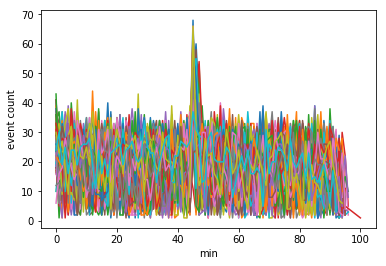

In [720]:
for i in range(0,len(df.game_id.unique())):
    y = df[df.game_id==i].groupby(['min']).count()['event_no']
    x = list(y.index)
    plt.plot(x, y)
    plt.xlabel('min')
    plt.ylabel('event count')
    #plt.title('event count in game '+str(i))
    #plt.savefig('../fig/'+'event count in game '+str(i)+'.png')
plt.show()

In [767]:
df = construct_ball_team_df()


















  0%|          | 0/190 [00:00<?, ?it/s]
















  1%|          | 1/190 [00:02<08:49,  2.80s/it]
















  1%|          | 2/190 [00:05<08:43,  2.78s/it]
















  2%|▏         | 3/190 [00:08<09:01,  2.90s/it]
















  2%|▏         | 4/190 [00:11<09:04,  2.93s/it]
















  3%|▎         | 5/190 [00:14<08:45,  2.84s/it]
















  3%|▎         | 6/190 [00:16<08:26,  2.75s/it]
















  4%|▎         | 7/190 [00:19<08:35,  2.82s/it]
















  4%|▍         | 8/190 [00:22<08:32,  2.81s/it]
















  5%|▍         | 9/190 [00:25<08:12,  2.72s/it]
















  5%|▌         | 10/190 [00:27<08:09,  2.72s/it]
















  6%|▌         | 11/190 [00:30<08:14,  2.76s/it]
















  6%|▋         | 12/190 [00:34<08:40,  2.92s/it]
















  7%|▋         | 13/190 [00:36<08:32,  2.90s/it]
















  7%|▋         | 14/190 [00:39<08:30,  2.90s/it]
















  8%|▊         | 15/190 [0

 37%|███▋      | 70/190 [03:16<05:26,  2.72s/it]
















 37%|███▋      | 71/190 [03:19<05:25,  2.73s/it]
















 38%|███▊      | 72/190 [03:22<05:22,  2.73s/it]
















 38%|███▊      | 73/190 [03:25<05:29,  2.82s/it]
















 39%|███▉      | 74/190 [03:27<05:24,  2.80s/it]
















 39%|███▉      | 75/190 [03:30<05:23,  2.81s/it]
















 40%|████      | 76/190 [03:33<05:18,  2.79s/it]
















 41%|████      | 77/190 [03:36<05:18,  2.82s/it]
















 41%|████      | 78/190 [03:39<05:15,  2.82s/it]
















 42%|████▏     | 79/190 [03:42<05:30,  2.98s/it]
















 42%|████▏     | 80/190 [03:45<05:16,  2.87s/it]
















 43%|████▎     | 81/190 [03:47<05:08,  2.83s/it]
















 43%|████▎     | 82/190 [03:50<04:55,  2.73s/it]
















 44%|████▎     | 83/190 [03:52<04:44,  2.66s/it]
















 44%|████▍     | 84/190 [03:55<04:50,  2.74s/it]
















 45%|████▍     | 85/190 [

 74%|███████▎  | 140/190 [06:32<02:16,  2.72s/it]
















 74%|███████▍  | 141/190 [06:35<02:13,  2.72s/it]
















 75%|███████▍  | 142/190 [06:37<02:12,  2.77s/it]
















 75%|███████▌  | 143/190 [06:40<02:13,  2.85s/it]
















 76%|███████▌  | 144/190 [06:43<02:12,  2.89s/it]
















 76%|███████▋  | 145/190 [06:47<02:14,  2.99s/it]
















 77%|███████▋  | 146/190 [06:49<02:07,  2.90s/it]
















 77%|███████▋  | 147/190 [06:52<02:03,  2.87s/it]
















 78%|███████▊  | 148/190 [06:55<01:58,  2.82s/it]
















 78%|███████▊  | 149/190 [06:58<01:56,  2.84s/it]
















 79%|███████▉  | 150/190 [07:00<01:51,  2.78s/it]
















 79%|███████▉  | 151/190 [07:03<01:50,  2.84s/it]
















 80%|████████  | 152/190 [07:06<01:48,  2.86s/it]
















 81%|████████  | 153/190 [07:09<01:43,  2.80s/it]
















 81%|████████  | 154/190 [07:12<01:41,  2.83s/it]
















 82%|█████

In [783]:
df.groupby(['type_id']).count()
# 类别出现次数不平衡

,game_id,event_no,period_id,min,sec,team_id,keypass,assist,ball_related,ball_slope,x,y,field,zone,penal_zone,penal_point,ball_pos,game_time,time_dis_last_event,last_min,last_sec,last_type_id,last_team_id,last_keypass,last_assist,last_ball_related,last_ball_slope,last_x,last_y,last_field,last_zone,last_penal_zone,last_penal_point,last_ball_pos,last_game_time,last_time_dis_last_event,next_ball_related,next_x,next_y,next_team
type_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,187005,187005,187005,187005,187005,187005,187005,187005,187005,186815,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,186823,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005,187005
2.0,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833
3.0,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984,6984
4.0,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792
5.0,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24188,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192,24192
6.0,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482,3482
7.0,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164,7164
8.0,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773,5773
10.0,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063


In [792]:
files[6]

'f24-24-2016-853244-eventdetails.xml'

In [ ]:
df = df.drop(df[(df['min']<=10) & (df['period_id']==0)].index, axis=0) # drop the events before 10mins in period 1
df = df.drop(df[(df['min']<=55) & (df['period_id']==1)].index, axis=0) # drop the events before 10mins in period 2

In [449]:
def train_bst_class(X_tr, y_tr, X_val, y_val, feature_names='auto'):
    params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': {'binary_logloss', 'auc'},  #二进制对数损失
    'num_leaves': 5,  
    'max_depth': 6,  
    'min_data_in_leaf': 450,  
    'learning_rate': 0.01,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.95,  
    'bagging_freq': 5,  
    'lambda_l1': 1,    
    'lambda_l2': 0.001,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.2,  
    'verbose': 5,  
    'is_unbalance': True  
    }  

    MAX_ROUNDS = 10000
    dtrain = lgb.Dataset(
        X_tr, label=y_tr,
    )
    dval = lgb.Dataset(
        X_val, label=y_val, reference=dtrain, 
        feature_name=list(feature_names),
        categorical_feature = categorical_feature
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100,
        feature_name=list(feature_names),
    )
    return bst


In [437]:
def train_bst_reg(X_tr, y_tr, X_val, y_val, feature_names='auto'):
    params = {
        'boosting': 'gbdt',
        'num_leaves': 31,
        'objective': 'regression',
        'min_data_in_leaf': 300,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 2,
        'metric': 'rmse',
        'num_threads': 8, 
        'min_data': 1, 
        'min_data_in_bin': 1, 
        # 'device': 'gpu', 
    }
    
    MAX_ROUNDS = 5000
    dtrain = lgb.Dataset(
        X_tr, label=y_tr,
    )

    dval = lgb.Dataset(
        X_val, label=y_val, reference=dtrain, 
        feature_name=list(feature_names),
        categorical_feature = categorical_feature
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100,
        feature_name=list(feature_names),
    )
    return bst


In [410]:
def get_train_val(tr_X, tr_y):
    val_num = int(len(tr_X) / 10)
    return tr_X.iloc[:-val_num].values, tr_y[:-val_num].values, tr_X.iloc[-val_num:].values, tr_y.iloc[-val_num:].values

In [435]:
categorical_feature = ['period_id', 'type_id', 'team_id', 'game_time','last_type_id', 'last_team_id',
                       'keypass', 'last_keypass', 'assist', 'last_assist', 'field' ,'penal_zone', 
                       'penal_point', 'zone', 'last_field', 'last_penal_zone', 'last_zone', 'last_penal_point']

In [567]:
df_train_X = train_df[train_df.columns[0:-4]]
df_train_y = train_df[train_df.columns[-4:]]
X_tr, y_tr, X_val, y_val = get_train_val(df_train_X, df_train_y)

print("Training x model...")
bst_x = train_bst_reg(X_tr, y_tr[:,0], X_val, y_val[:,0], feature_names=df_train_X.columns)
print("Training y model...")
bst_y = train_bst_reg(X_tr, y_tr[:,1], X_val, y_val[:,1], feature_names=df_train_X.columns)

print("Training team model...")
bst_t = train_bst_class(X_tr, y_tr[:,2], X_val, y_val[:,2], feature_names=df_train_X.columns)


Training x model...


/Users/mhliu/Program/anaconda3/envs/ml/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 12.8641	valid_1's rmse: 12.7726
[200]	training's rmse: 12.5405	valid_1's rmse: 12.5614
[300]	training's rmse: 12.3724	valid_1's rmse: 12.486
[400]	training's rmse: 12.2468	valid_1's rmse: 12.4518
[500]	training's rmse: 12.1458	valid_1's rmse: 12.442
[600]	training's rmse: 12.0533	valid_1's rmse: 12.4253
[700]	training's rmse: 11.9648	valid_1's rmse: 12.4183
Early stopping, best iteration is:
[686]	training's rmse: 11.9749	valid_1's rmse: 12.4161
Training y model...


/Users/mhliu/Program/anaconda3/envs/ml/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 17.4831	valid_1's rmse: 17.6925
[200]	training's rmse: 17.2607	valid_1's rmse: 17.5985
[300]	training's rmse: 17.1009	valid_1's rmse: 17.5607
[400]	training's rmse: 16.9622	valid_1's rmse: 17.5344
[500]	training's rmse: 16.8332	valid_1's rmse: 17.5112
[600]	training's rmse: 16.7218	valid_1's rmse: 17.5082
Early stopping, best iteration is:
[570]	training's rmse: 16.7564	valid_1's rmse: 17.5063
Training team model...


/Users/mhliu/Program/anaconda3/envs/ml/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.595656	training's auc: 0.779596	valid_1's binary_logloss: 0.594555	valid_1's auc: 0.781769
[200]	training's binary_logloss: 0.560895	training's auc: 0.801376	valid_1's binary_logloss: 0.558531	valid_1's auc: 0.803274
[300]	training's binary_logloss: 0.540554	training's auc: 0.816089	valid_1's binary_logloss: 0.537733	valid_1's auc: 0.817834
[400]	training's binary_logloss: 0.531089	training's auc: 0.823009	valid_1's binary_logloss: 0.528206	valid_1's auc: 0.825287
[500]	training's binary_logloss: 0.527824	training's auc: 0.826094	valid_1's binary_logloss: 0.52529	valid_1's auc: 0.828195
[600]	training's binary_logloss: 0.524427	training's auc: 0.82829	valid_1's binary_logloss: 0.522017	valid_1's auc: 0.830307
[700]	training's binary_logloss: 0.51889	training's auc: 0.832855	valid_1's binary_logloss: 0.516591	valid_1's auc: 0.83493
[800]	training's binary_logloss: 0.516344	training's auc: 0.

[6600]	training's binary_logloss: 0.461393	training's auc: 0.86858	valid_1's binary_logloss: 0.46256	valid_1's auc: 0.867728
[6700]	training's binary_logloss: 0.46122	training's auc: 0.868687	valid_1's binary_logloss: 0.462439	valid_1's auc: 0.867792
[6800]	training's binary_logloss: 0.461002	training's auc: 0.868838	valid_1's binary_logloss: 0.462259	valid_1's auc: 0.867918
[6900]	training's binary_logloss: 0.460703	training's auc: 0.869025	valid_1's binary_logloss: 0.462009	valid_1's auc: 0.868061
[7000]	training's binary_logloss: 0.460524	training's auc: 0.869137	valid_1's binary_logloss: 0.461901	valid_1's auc: 0.86811
[7100]	training's binary_logloss: 0.460155	training's auc: 0.869332	valid_1's binary_logloss: 0.461566	valid_1's auc: 0.868288
[7200]	training's binary_logloss: 0.459788	training's auc: 0.869477	valid_1's binary_logloss: 0.461268	valid_1's auc: 0.868384
[7300]	training's binary_logloss: 0.459545	training's auc: 0.869633	valid_1's binary_logloss: 0.461085	valid_1's au

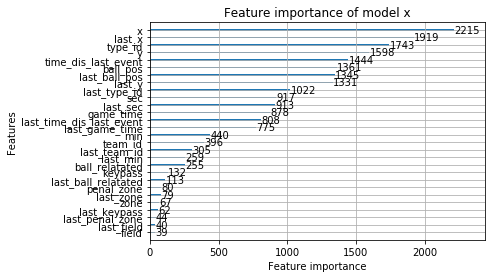

In [568]:
lgb.plot_importance(bst_x, max_num_features=30)
plt.title("Feature importance of model x")
plt.show()

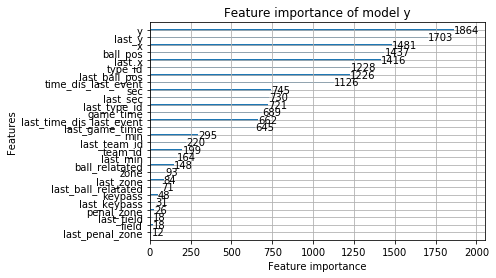

In [569]:
lgb.plot_importance(bst_y, max_num_features=30)
plt.title("Feature importance of model y")
plt.show()

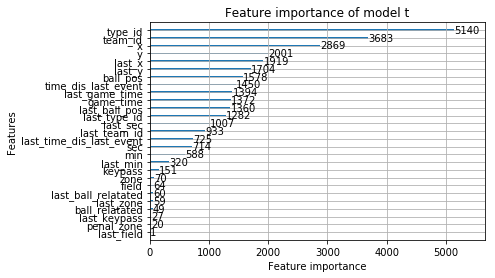

In [570]:
lgb.plot_importance(bst_t, max_num_features=30)
plt.title("Feature importance of model t")
plt.show()